In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math
%matplotlib inline

In [2]:
# Functions

def symbol_to_path(symbol, base_dir = 'data'):
    '''Return CSV file path given ticker symbol'''
    return os.path.join(base_dir, '{}.csv'.format(str(symbol)))

def get_data(symbols, dates):
    '''Read stock data (adjusted close) given symbols, from CSV files'''
    df = pd.DataFrame(index = dates)
    if 'SPY' not in symbols:  # Add SPY for reference, if absent
        symbols.insert(0,'SPY')
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), 
                          index_col = 'Date', 
                          parse_dates = True, 
                          usecols = ['Date', 'Adj Close'], 
                          na_values = ['nan'])
        df_temp = df_temp.rename(columns = {'Adj Close': symbol})
        df = df.join(df_temp)
        if symbol == 'SPY': # drop dates SPY did not trade
            df = df.dropna(subset=['SPY'])
    return df

def plot_data(df, title = 'Stock prices', ylabel = 'Price'):
    '''Plot stock prices'''
    ax = df.plot(title = title, fontsize = 12)
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    plt.show()
    
def get_bollinger_bands(rm, rstd):
    '''Return upper and lower Bollinger bands'''
    upper_band = rm + 2 * rstd
    lower_band = rm - 2 * rstd
    return upper_band, lower_band

def get_rolling_mean(df, window):
    return pd.rolling_mean(df, window = window)

def get_rolling_std(df, window):
    return pd.rolling_std(df, window = window)

def compute_daily_returns(df):
    '''Compute and return daily return values using pandas'''
    daily_returns = (df / df.shift(1)) - 1 # pandas shifts *back*
    daily_returns.ix[0,:] = 0 # pandas puts NaNs in row 0
    return daily_returns

def compute_cumulative_returns(df):
    '''Compute and return cumulative return values'''
    cum_returns = df.copy() # copy dataframe to match size, rows and columns
    cum_returns = (df/df.ix[0,:].values) - 1
    return cum_returns

def normalize_data(df):
    '''Normalize stock prices using the first row of data frame.'''
    return df/df.ix[0,:]

In [3]:
# Approach:

# start_val = 1000000
# start_date = 2009-01-01
# end_date = 2011-12-31
# symbols = ['SPY', 'XOM', 'GOOG', 'GLD']
# allocs = [0.4, 0.4, 0.1, 0.1]

# prices = get_data
# normed = prices / prices[0]
# alloced = normed * allocs
# pos_vals = alloced * start_val
# port_val = pos_vals.sum(axis = 1)

# Calculate portfolio statistics
# 1. calculate daily returns
# 2. exclude first day (always 0): daily_rets = daily_rets[1:]
# 3. calculate: 
# cum_ret = (port_val[-1]/port_val[0] - 1)
# avg_daily_ret = daily_rets.mean()
# std_daily_ret = daily_rets.std()
# Sharpe_ratio 
    # (risk, return, risk-free rate of return)
    # mean(daily_rets - daily_rf)/std(daily_rets - daily_rf)
    # Risk free - LIBOR, 3mo T-bill, 0%
    # Risk free is a constant, usually
    # Risk free daily = (1 + rf-rate)-252...or 0
    # mean(daily_rets - daily_rf)/std(daily_rets)
    # can vary widely depending on sampling frequency
    # SR is an annual measure
    # SR_annual = k * SR, where k = sqrt(# samples per year)
    # SR = sqrt(252) * mean(diff)/std

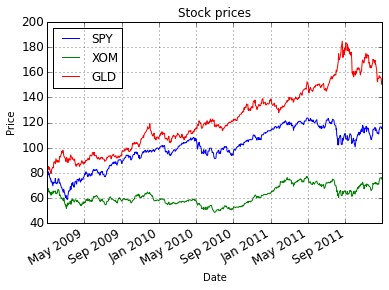

SPY    0.226840
XOM   -0.132730
GLD    0.579484
dtype: float64
2009-01-02    900000.000000
2009-01-05    897448.207974
2009-01-06    894353.444089
2009-01-07    869501.068676
2009-01-08    877191.842363
dtype: float64


In [4]:
# Sharpe Ratio

start_val = 1000000
start_date = '2009-01-01'
end_date = '2011-12-31'
symbols = ['SPY', 'XOM', 'GLD']
allocs = [0.4, 0.4, 0.1]

dates = pd.date_range(start_date, end_date)

df = get_data(symbols, dates)

plot_data(df)

def calculate_portfolio_value(df, start_val, allocs):
    # prices = get_data
    prices = df
    
    # normed = prices / prices[0]
    normed = prices.divide(prices.ix[0])

    # alloced = normed * allocs
    alloced = normed.multiply(allocs)
    
    # pos_vals = alloced * start_val
    pos_vals = alloced * start_val
    
    # port_val = pos_vals.sum(axis = 1)
    port_val = pos_vals.sum(axis = 1)
    
    return port_val

def calculate_SR(df, rf_arr):
    '''Calculate Sharpes ratio given a df of daily prices
    and annual risk free rate of return'''
    
    daily_ret = compute_daily_returns(df)
    
    # remove first row
    daily_ret = daily_ret[1:]
    
    # convert risk-free ror to daily
    daily_rf = (1 + rf_arr)**(1/252.0) - 1
    
    # calculate risk adjusted daily returns
    risk_adj = daily_ret - daily_rf
    
    SR = math.sqrt(250) * risk_adj.mean() / risk_adj.std()
    return SR
    
print calculate_SR(df, .1) 
print calculate_portfolio_value(df, start_val, allocs).head()


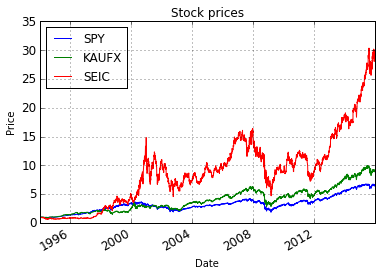

SPY      0.524987
KAUFX    0.597554
SEIC     0.576294
dtype: float64


In [11]:
symbols = ['SPY', 'KAUFX', 'SEIC']  # SEIC
dates = pd.date_range('1994-01-01', '2015-12-31')

df = get_data(symbols, dates)

df1 = normalize_data(df)

plot_data(df1)

print calculate_SR(df, .0025)